# Lesson 6 — NLP: From Words to Embeddings

This notebook explores how we turn text into numbers that neural networks can understand. We will cover:
1. **Tokenization & Vocabulary**: Converting strings to integer IDs.
2. **PyTorch Embeddings**: Using `nn.Embedding` to map IDs to dense vectors.
3. **Word Math (Word2Vec)**: Using pretrained embeddings to perform semantic arithmetic.

In [1]:
# !pip install torch matplotlib scikit-learn gensim
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Ensure reproducibility
torch.manual_seed(42)

## 1. Tokenization and Vocabulary

Before a model sees text, we must break it into **tokens** and map those tokens to integer **IDs**.

In [2]:
# A simple raw sentence
text = "I really liked this movie !"

# 1. Tokenization (splitting by space for simplicity)
tokens = text.lower().split()
print(f"Tokens: {tokens}")

# 2. Build Vocabulary (map token -> id)
# We typically reserve 0 for padding, 1 for unknown words
vocab = {"<pad>": 0, "<unk>": 1}
for token in tokens:
    if token not in vocab:
        vocab[token] = len(vocab)

print(f"Vocabulary: {vocab}")

# 3. Integer Encoding (tokens -> ids)
ids = [vocab.get(t, vocab["<unk>"]) for t in tokens]
print(f"IDs: {ids}")

Tokens: ['i', 'really', 'liked', 'this', 'movie', '!']
Vocabulary: {'<pad>': 0, '<unk>': 1, 'i': 2, 'really': 3, 'liked': 4, 'this': 5, 'movie': 6, '!': 7}
IDs: [2, 3, 4, 5, 6, 7]


## 2. PyTorch Embeddings (`nn.Embedding`)

The `nn.Embedding` layer acts as a lookup table. It stores a trainable vector for each word in the vocabulary.

In [3]:
vocab_size = len(vocab)
embedding_dim = 8  # Keeping it small for this demo

# Define the embedding layer
emb_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

# Convert our list of IDs to a torch tensor
input_ids = torch.tensor(ids)

# Look up the vectors
vectors = emb_layer(input_ids)

print(f"Input shape: {input_ids.shape} (sequence length)")
print(f"Output shape: {vectors.shape} (sequence length, embedding dim)")
print("\nFirst word vector:\n", vectors[0].detach().numpy())

Input shape: torch.Size([6]) (sequence length)
Output shape: torch.Size([6, 8]) (sequence length, embedding dim)

First word vector:
 [ 1.6423169  -0.15959732 -0.49739748  0.43958923 -0.75813115  1.0783176
  0.8008005   1.6806206 ]


These vectors are currently random. In a real task (like sentiment analysis), we would train the model, and these vectors would update via backpropagation to capture meaning.

## 3. Pretrained Word Vectors & "Word Math"

Instead of training from scratch, we can load **pretrained** embeddings (like Word2Vec or GloVe) that have already learned rich semantic relationships from massive text corpora.

We will use `gensim` to load a small version of GloVe vectors (which have similar properties to Word2Vec).

In [4]:
import gensim.downloader as api

# Load pretrained vectors (GloVe 50-dimensional vectors)
# This might take a minute to download (~66MB)
print("Loading pretrained model...")
word_vectors = api.load("glove-wiki-gigaword-50")
print("Model loaded!")

Loading pretrained model...
Model loaded!


### Similarity
Words with similar meanings should have high cosine similarity.

In [5]:
w1 = "good"
w2 = "great"
w3 = "bad"

sim_good_great = word_vectors.similarity(w1, w2)
sim_good_bad = word_vectors.similarity(w1, w3)

print(f"Similarity between '{w1}' and '{w2}': {sim_good_great:.4f}")
print(f"Similarity between '{w1}' and '{w3}': {sim_good_bad:.4f}")

Similarity between 'good' and 'great': 0.7983
Similarity between 'good' and 'bad': 0.7965


### Word Math (Analogies)

The classic example of vector arithmetic:
$$ \text{King} - \text{Man} + \text{Woman} \approx \text{Queen} $$

In [6]:
def show_analogy(pos, neg):
    result = word_vectors.most_similar(positive=pos, negative=neg, topn=1)
    print(f"{pos[0]} - {neg[0]} + {pos[1]} = {result[0][0]} ({result[0][1]:.2f})")

# King - Man + Woman = ?
show_analogy(pos=['king', 'woman'], neg=['man'])

# France - Paris + Rome = ?
show_analogy(pos=['france', 'rome'], neg=['paris'])

# Actor - Man + Woman = ?
show_analogy(pos=['actor', 'woman'], neg=['man'])

king - man + woman = queen (0.85)
france - paris + rome = italy (0.86)
actor - man + woman = actress (0.94)


### Finding the "Odd One Out"
Which word doesn't belong in the list?

In [7]:
words_list = ["apple", "banana", "orange", "car"]
odd_one = word_vectors.doesnt_match(words_list)
print(f"In list {words_list}, the odd one is: '{odd_one}'")

words_list_2 = ["breakfast", "lunch", "dinner", "python"]
odd_one_2 = word_vectors.doesnt_match(words_list_2)
print(f"In list {words_list_2}, the odd one is: '{odd_one_2}'")

In list ['apple', 'banana', 'orange', 'car'], the odd one is: 'car'
In list ['breakfast', 'lunch', 'dinner', 'python'], the odd one is: 'python'


### Visualization (PCA)
We can project these 50-dimensional vectors down to 2D to visualize relationships.

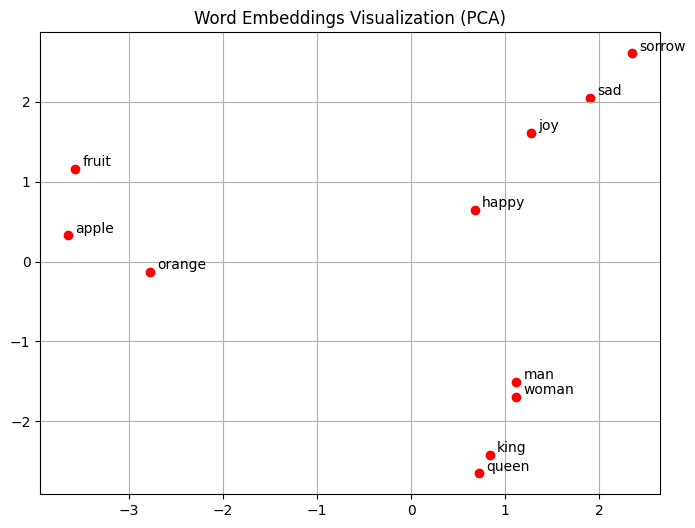

In [8]:
from sklearn.decomposition import PCA

def plot_words(words):
    # Get vectors
    vectors = [word_vectors[w] for w in words]
    
    # Reduce to 2D
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c='red')
    
    for i, word in enumerate(words):
        plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), xytext=(5, 2), textcoords='offset points')
        
    plt.title("Word Embeddings Visualization (PCA)")
    plt.grid(True)
    plt.show()

target_words = [
    "king", "queen", "man", "woman", 
    "apple", "orange", "fruit",
    "happy", "sad", "joy", "sorrow"
]

plot_words(target_words)

## 4. Mini Skip-Gram Training Example

To see how Skip-Gram learns embeddings, we can train a tiny model on a toy corpus. This is **not** meant for quality, just for intuition.

In [ ]:
import torch.nn.functional as F
from collections import Counter

# Tiny toy corpus
corpus = [
    "i love this movie",
    "i hate this movie",
    "this film was great",
    "this film was terrible",
]

# Build vocabulary
tokens = [w for sent in corpus for w in sent.split()]
vocab = {"<pad>": 0}
for w in tokens:
    if w not in vocab:
        vocab[w] = len(vocab)

id2word = {i: w for w, i in vocab.items()}
vocab_size = len(vocab)

def generate_skipgram_pairs(sentence, window_size=2):
    words = sentence.split()
    ids = [vocab[w] for w in words]
    pairs = []
    for i, center_id in enumerate(ids):
        for j in range(max(0, i - window_size), min(len(ids), i + window_size + 1)):
            if i == j:
                continue
            context_id = ids[j]
            pairs.append((center_id, context_id))
    return pairs

pairs = []
for sent in corpus:
    pairs.extend(generate_skipgram_pairs(sent))

print(f"Number of (center, context) pairs: {len(pairs)}")

class SkipGram(nn.Module):
    def __init__(self, vocab_size, emb_dim=16):
        super().__init__()
        self.center_emb = nn.Embedding(vocab_size, emb_dim)
        self.context_emb = nn.Embedding(vocab_size, emb_dim)

    def forward(self, center_ids):
        # center_ids: (N,)
        center_vecs = self.center_emb(center_ids)          # (N, d)
        context_matrix = self.context_emb.weight.t()       # (d, V)
        logits = center_vecs @ context_matrix              # (N, V)
        return logits                                      

model = SkipGram(vocab_size, emb_dim=16)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

# Prepare training tensors
centers = torch.tensor([c for c, _ in pairs])
contexts = torch.tensor([ctx for _, ctx in pairs])

for epoch in range(50):
    logits = model(centers)
    loss = loss_fn(logits, contexts)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}: loss = {loss.item():.4f}")

def nearest_neighbors(query, top_k=3):
    if query not in vocab:
        return []
    with torch.no_grad():
        emb = model.center_emb.weight  # (V, d)
        q_vec = emb[vocab[query]]
        sims = F.cosine_similarity(q_vec.unsqueeze(0), emb)  # (V,)
        # take top_k + 1 to skip the query word itself
        top_idx = torch.topk(sims, top_k + 1).indices.tolist()
        result = []
        for idx in top_idx:
            w = id2word[idx]
            if w != query:
                result.append(w)
            if len(result) == top_k:
                break
    return result

for w in ["love", "hate", "great", "terrible"]:
    if w in vocab:
        print(f"Nearest to '{w}': {nearest_neighbors(w)}")


Number of (center, context) pairs: 40
Epoch 10: loss = 1.6088
Epoch 20: loss = 1.3691
Epoch 30: loss = 1.3112
Epoch 40: loss = 1.2909
Epoch 50: loss = 1.2831
Nearest to 'love': ['hate', 'film', 'i']
Nearest to 'hate': ['love', 'film', 'movie']
Nearest to 'great': ['<pad>', 'terrible', 'movie']
Nearest to 'terrible': ['was', 'this', 'film']


### Mini CBOW Training Example

CBOW does the opposite of Skip-Gram: it takes context words as input and predicts the missing center word.

In [10]:
# Reuse the same tiny corpus and vocabulary from above
corpus = [
    "i love this movie",
    "i hate this movie",
    "this film was great",
    "this film was terrible",
]

tokens = [w for sent in corpus for w in sent.split()]
vocab = {"<pad>": 0}
for w in tokens:
    if w not in vocab:
        vocab[w] = len(vocab)

id2word = {i: w for w, i in vocab.items()}
vocab_size = len(vocab)

def generate_cbow_data(corpus, window_size=2):
    data = []
    for sent in corpus:
        words = sent.split()
        ids = [vocab[w] for w in words]
        for i, center_id in enumerate(ids):
            context_ids = []
            for j in range(max(0, i - window_size), min(len(ids), i + window_size + 1)):
                if i == j:
                    continue
                context_ids.append(ids[j])
            if context_ids:
                data.append((context_ids, center_id))
    return data

cbow_data = generate_cbow_data(corpus, window_size=2)
print(f"Number of (context, center) examples: {len(cbow_data)}")

class CBOW(nn.Module):
    def __init__(self, vocab_size, emb_dim=16):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.fc = nn.Linear(emb_dim, vocab_size)

    def forward(self, context_ids):
        # context_ids: (batch, ctx_len)
        emb = self.embedding(context_ids)          # (batch, ctx_len, d)
        ctx_mean = emb.mean(dim=1)                # (batch, d)
        logits = self.fc(ctx_mean)                # (batch, V)
        return logits

cbow_model = CBOW(vocab_size, emb_dim=16)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cbow_model.parameters(), lr=0.05)

for epoch in range(50):
    total_loss = 0.0
    for context_ids, center_id in cbow_data:
        context_tensor = torch.tensor(context_ids).unsqueeze(0)  # (1, ctx_len)
        target = torch.tensor([center_id])                       # (1,)

        logits = cbow_model(context_tensor)
        loss = loss_fn(logits, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        avg_loss = total_loss / len(cbow_data)
        print(f"Epoch {epoch + 1}: avg loss = {avg_loss:.4f}")

# Example: predict center word from context
test_context = ["i", "movie"]
ctx_ids = [vocab[w] for w in test_context]
ctx_tensor = torch.tensor(ctx_ids).unsqueeze(0)
with torch.no_grad():
    logits = cbow_model(ctx_tensor)
    pred_id = logits.argmax(dim=-1).item()
print(f"Predicted center word for context {test_context}: '{id2word[pred_id]}'")


Number of (context, center) examples: 16
Epoch 10: avg loss = 0.6469
Epoch 20: avg loss = 0.6108
Epoch 30: avg loss = 0.5948
Epoch 40: avg loss = 0.5858
Epoch 50: avg loss = 0.5799
Predicted center word for context ['i', 'movie']: 'this'
